# Introduction


This notebook concerns the interpretation of data acquired by an 'AC-S' 
spectrophotometer on the Oregon Slope Base shallow profiler. This is 
a site of the Regional Cabled Array component of the Ocean Observatories Initiative. 


The AC-S instrument operates for two
intervals each day, each approximately one hour. These are during 
local midnight and local noon profiler ascents. Two measurements are made across
83 spectral channels: Optical absorption (abbreviated 'a') and 
beam attenuation (denoted 'c'). 
The sampling rate is about four samples per second. 

To get a sense of the data volume: 7200 seconds per day x 4 samples 
per second x 2 sample types x 83 channels per sample comes to 
about 5 million floating point values. In terms of rate of ascent,
3600 seconds corresponds to 180 meters in depth or 5 cm / second.


Ascent = 60 minutes, 180 meters: 300 cm / 60 sec or 5 cm/sec. The vertical
bin width used below is 20 cm or 4 sec of data, approximately 16 samples. 
(Another option: 25 cm or about 20 samples.)


Optical absorbance ($a$) 
is understood to be photon absorption by material in
the water column. Beam
attenuation ($c$) is due to a combination of optical absorption $a$
and scattering of light $b$, by seawater and other matter in the water column.
$a \; + \; b \; = \; c$. 

## For review / revision of this notebook


- Intro corrections + list calculation objectives
- $a$ described as a superposition of multiple signals (Ali)
- Short wavelength lamp is low intensity (Ian?): Weak detection; noise; exclude from fit
- Mathematics of an exponential fit 
    - Emphasis on DC offsets, indexing wavelenghths vs actual wavelengths, etc
    - Example: Fitting to wavelength in nm runs aground "1. 1. X"
- Review wavelength channels, channel width, overlap
    - Verify (Chris) wav_a and wav_c correspond to $a$ and $c$
- Justify median filter; verify std calculation
- Jan thru May 2021 4.2GB
- 32 Data variables
- First redux: 12 days, 2 wavelengths, $a$ and $c$
- Second redux: 1 profile March 13 noon local ascent, all channels
    - Compare Chlor-A from FLORT
- Challenge: Eliminate NaN properly
- Challenge: Reduce data to depth bins quickly
    - Still to try: Use the DataFrame method
- Document the data size reduction
    - Extract one representative ascent, all channels, stripped down to A, C for the repo
    - Attributes are cumbersome
- Chart mean for comparison?
- Exponential decay fit verify
    - Truncate both ends?
- Comparisons
    - CDOM proxy to compare to FLORT CDOM (Ali)
    - ChlorA including 3-point estimate (Chris)
    - Quenching error tied to PAR
- What else? 



# Part 0. Imports, utilities


This notebook uses **`SpectrophotometerModule.py`** 
as well as profiler metadata. 

In [1]:
# Set up this notebook to use code from an accompanying Python module file
from SpectrophotometerModule import *
print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


# Part 1. Consolidating source data + load/check

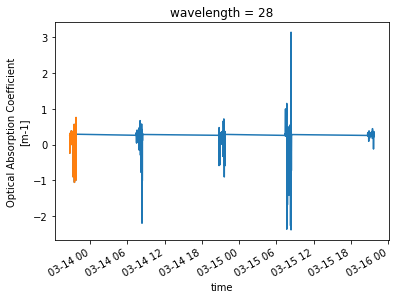

In [2]:
# For prep see SpectrophotometerModule.py section "Create subset file 1"
s = xr.open_dataset('../RepositoryData/rca/optaa/2021-MAR-13_thru_16_chs_28_and_56.nc')
s.oa.sel(wavelength=28).plot()
s.oa.sel(wavelength=28).isel(time=range(14000)).plot()

#### Interpretation

Use `!ls -al` to determine this file is 4.3MB. It consists of two wavelengths (channels 28 and 56) and holds both $a$ and $c$ data. 
There are five profiles shown above spanning 2+ days; again two profile ascents per day. Times shown are in UTC so the first
profile (orange) occurs at local noon on March 13 2021. The ascent runs from 192 to 15 meters depth over one hour. 


As a next step we chart $a$ and $c$ with depth.

2021-03-13 20:42:00


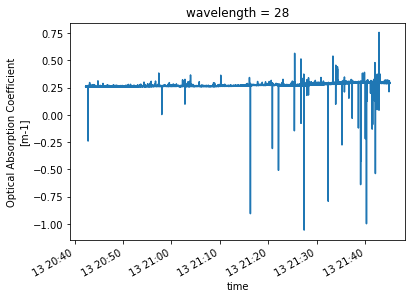

In [3]:
# In profile 'p': index 8 is the first ascent of 2021 where the spectrophotometer collected data
s = xr.open_dataset('../RepositoryData/rca/optaa/2021-MAR-13_thru_16_chs_28_and_56.nc')
channel = 28
day = dt64_from_doy(2021, 72)         # March 13
i = GenerateTimeWindowIndices(p, day, day, noon0, noon1)
t0 = p["ascent_start"][i[0]]
t1 = p["ascent_end"][i[0]]
print(t0)
s.sel(wavelength=channel).sel(time=slice(t0, t1)).oa.plot()

### Continuing here with the original program


Can scroll down to ***More of the gamma reduction***

## Part 2. Beam attenuation and optical absorption charts


The four charting code blocks below demonstrate overlaying ('bundle view') 10 days worth of profiles. 
These are separated into noon and midnight profiles; and since we have both beam attenuation and
optical absorption the total is 2 x 2 = 4 charts. 


The work halts here for the moment (with some coding remarks at the bottom) because the data are quite noisy. 
A single profile takes about 60 minutes; which at 2Hz sampling is 7200 data points. Over ten days
this will come to 70k data points *per channel*. There are about 80 working channels. This sketch
is confined to only three of these: 0 (or 1), 40 and 80. So in summary we have four charts with about
one million data points and a big *gap* in the context needed to go further...

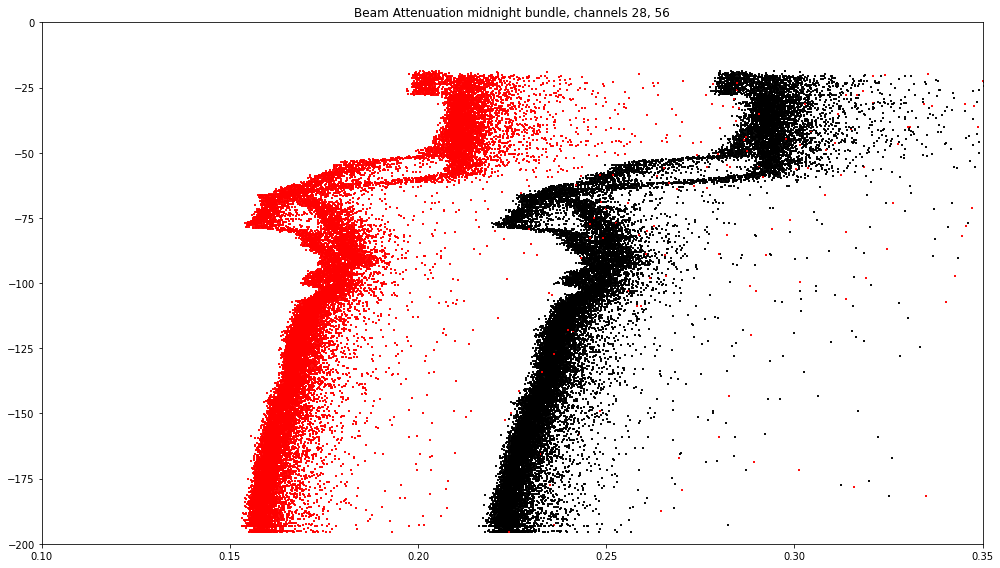

In [4]:
pm = GenerateTimeWindowIndices(p, dt64_from_doy(2021, 72), dt64_from_doy(2021, 75), midn0, midn1)
pn = GenerateTimeWindowIndices(p, dt64_from_doy(2021, 72), dt64_from_doy(2021, 75), noon0, noon1)
nm, nn = len(pm), len(pn)

# midnight bundle, beam attenuation    
fig, ax = plt.subplots(figsize=(14, 8), tight_layout=True)

for i in range(nm):
    t0, t1 = p["ascent_start"][pm[i]], p["ascent_end"][pm[i]]
    ba =  s.sel(wavelength=28).sel(time=slice(t0,  t1)).ba
    z  = -s.sel(wavelength=28).sel(time=slice(t0, t1)).depth            # z is negated depth to imply below sea surface
    ax.scatter(ba, z, marker=',', s=1., color=colorBA28)               # plot: ax.plot(ba, z, ms = 4., color=colorBA40, mfc=colorBA40)
    ba = s.sel(wavelength=56).sel(time=slice(t0,  t1)).ba
    z  = -s.sel(wavelength=56).sel(time=slice(t0, t1)).depth
    ax.scatter(ba, z, marker=',', s=1., color=colorBA56)

ax.set(title = 'Beam Attenuation midnight bundle, channels 28, 56')
ax.set(xlim = (0.1, 0.35), ylim = (-200, 0.))
plt.show()

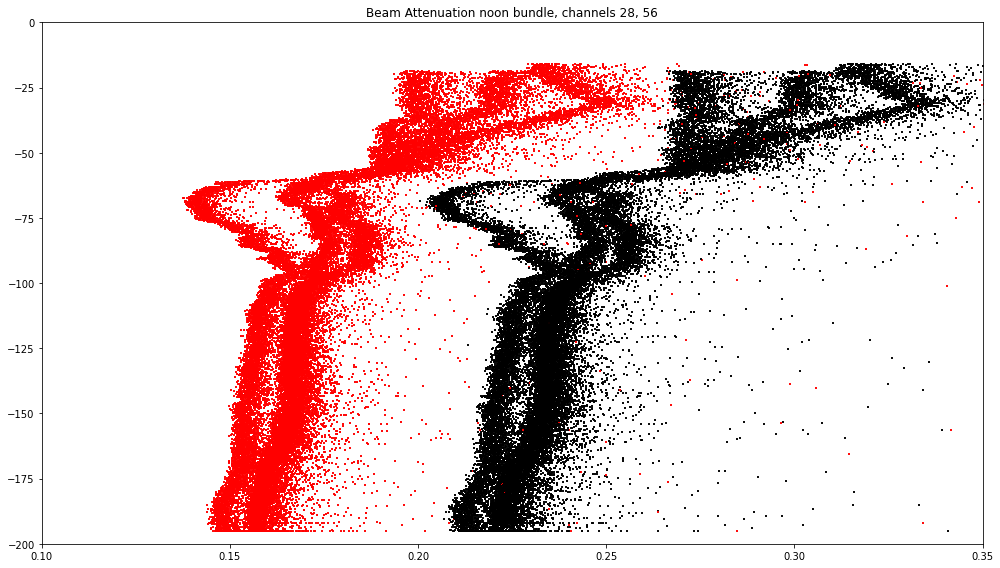

In [5]:
# noon bundle, beam attenuation    
fig, ax = plt.subplots(figsize=(14, 8), tight_layout=True)

for i in range(nn):
    t0, t1 = p["ascent_start"][pn[i]], p["ascent_end"][pn[i]]
    ba = s.sel(wavelength=28).sel(time=slice(t0,  t1)).ba
    z  = -s.sel(wavelength=28).sel(time=slice(t0, t1)).depth
    ax.scatter(ba, z, marker=',', s=1., color=colorBA28)
    ba = s.sel(wavelength=56).sel(time=slice(t0,  t1)).ba
    z  = -s.sel(wavelength=56).sel(time=slice(t0, t1)).depth
    ax.scatter(ba, z, marker=',', s=1., color=colorBA56)

ax.set(title = 'Beam Attenuation noon bundle, channels 28, 56')
ax.set(xlim = (0.1, 0.35), ylim = (-200, 0.))
plt.show()

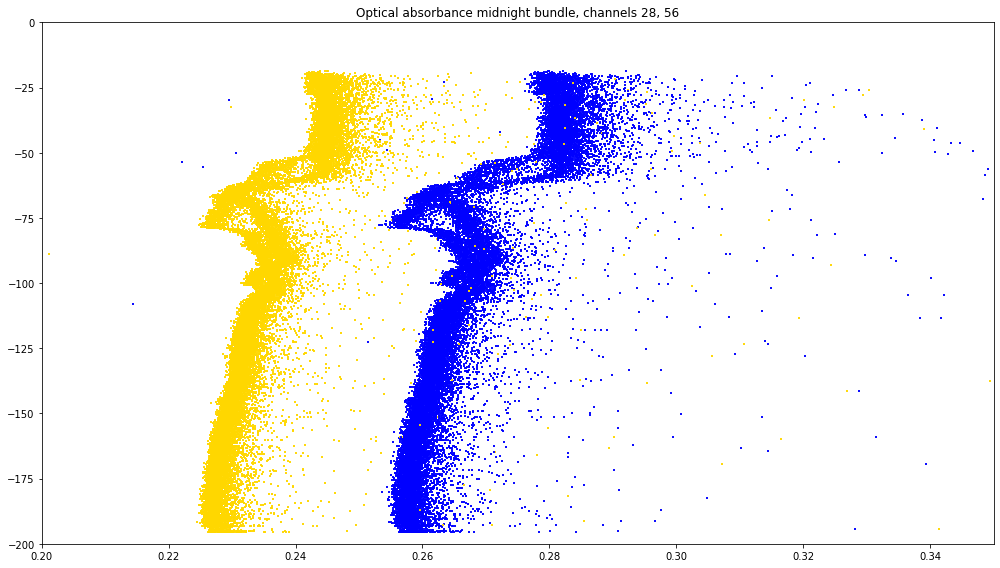

In [6]:
# midnight bundle, optical absorbance  
fig, ax = plt.subplots(figsize=(14, 8), tight_layout=True)

for i in range(nn):
    t0, t1 = p["ascent_start"][pm[i]], p["ascent_end"][pm[i]]
    oa = s.sel(wavelength=28).sel(time=slice(t0,  t1)).oa
    z  = -s.sel(wavelength=28).sel(time=slice(t0, t1)).depth
    ax.scatter(oa, z, marker=',', s=1., color=colorOA28)
    oa = s.sel(wavelength=56).sel(time=slice(t0,  t1)).oa
    z  = -s.sel(wavelength=56).sel(time=slice(t0, t1)).depth
    ax.scatter(oa, z, marker=',', s=1., color=colorOA56)

ax.set(title = 'Optical absorbance midnight bundle, channels 28, 56')
ax.set(xlim = (0.2, .35), ylim = (-200, 0.))
plt.show()

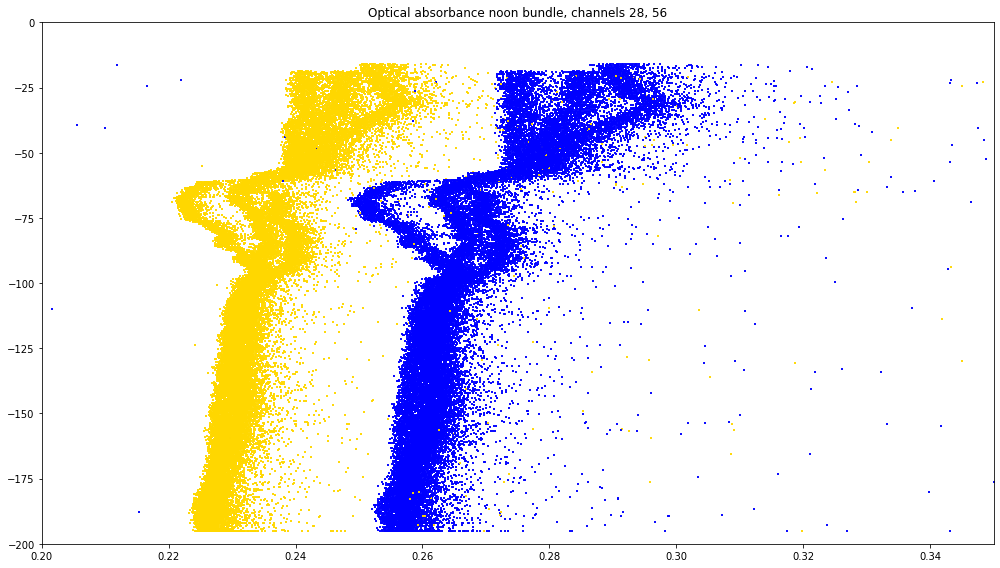

In [7]:
# noon bundle, optical absorbance  
fig, ax = plt.subplots(figsize=(14, 8), tight_layout=True)

for i in range(nn):
    t0, t1 = p["ascent_start"][pn[i]], p["ascent_end"][pn[i]]
    oa = s.sel(wavelength=28).sel(time=slice(t0,  t1)).oa
    z  = -s.sel(wavelength=28).sel(time=slice(t0, t1)).depth
    ax.scatter(oa, z, marker=',', s=1., color=colorOA28)
    oa = s.sel(wavelength=56).sel(time=slice(t0,  t1)).oa
    z  = -s.sel(wavelength=56).sel(time=slice(t0, t1)).depth
    ax.scatter(oa, z, marker=',', s=1., color=colorOA56)

ax.set(title = 'Optical absorbance noon bundle, channels 28, 56')
ax.set(xlim = (0.2, .35), ylim = (-200, 0.))
plt.show()

### Interpretation


The noisy nature of the data suggests some filtering. 
The mixed layer and pycnocline (50 to 75 meter depth) structure suggests building comparison with the 
March 2021 data found in the BioOptics notebook. 



A common data reduction approach is to slice the profile data as depth bins and
consider--for each bin--the spectral
dimension. Fitting a model of exponential decay will produce a single characteristic
paramter $\large{\gamma}$. These can be stacked with depth.


Begin by fixing depth: We can take the ascent profile and bin the samples to some depth 
interval. In what follows we us 20 cm intervals, corresponding to about 4 seconds of data
acquisition. We expect that wave action would introduce some noise to the signal.


For a given depth bin we can easily calculate four numbers from about 20 samples: 
$\normalsize{oa_{mean}, \; oa_{sd}, \; ba_{mean}, \; ba_{sd}}$. All four are
charted against wavelength for interest below. 


Along the wavelength axis we
can fit an exponential curve characterized by a decay constant $\gamma$.


$$\large{oa \; = \; A \; e^{-\gamma_{o} \; \lambda}}$$

$$\large{ba \; = \; B \; e^{-\gamma_{b} \; \lambda}}$$


The decay constant is an indication of particle size distribution. It can be estimated
via fit algorithm at each depth bin; and consequently charted against depth.


## Gamma reduction


There are a few items to cover at this point; so this is a temporary section to 
start some of that. 



Further down we have a Mar 13 - Mar 14 time slice giving just one profile ascent
from data file (temporarily) called `04.nc`. Time range is 1 hr, 2 min, 42 sec or
3762 seconds. Noon ascent March 13. 


- 2021-03-13T20:42:16.050669056
- 2021-03-13T21:45:08.062204416


- Fit the data to wavelength values
- Plot the data with depth axis oriented correctly
- Add a box filter version of the signal
- Drop Chlorophyll signal onto the same chart using a twin axis
- Same: Backscatter

In [8]:
acs=xr.open_dataset("../../data/rca/optaa/20210313.nc")
print(acs.wavelength_a)
wav_a = acs.wavelength_a.copy()
print(wav_a)

# Row 619 of the p[][] DataFrame is the ascent on noon March 13 2021
t0 = p['ascent_start'][619]
t1 = p['ascent_end'][619]

A = xr.open_dataset('../RepositoryData/rca/fluor/osb_chlora_march2021_1min.nc')
B = xr.open_dataset('../RepositoryData/rca/fluor/osb_backscatter_march2021_1min.nc')
C = xr.open_dataset('../RepositoryData/rca/fluor/osb_cdom_march2021_1min.nc')
P = xr.open_dataset('../RepositoryData/rca/par/osb_par_march2021_1min.nc')

A = A.dropna('time')
B = B.dropna('time')
C = C.dropna('time')
P = P.dropna('time')

A=A.sel(time=slice(t0, t1))
B=B.sel(time=slice(t0, t1))
C=C.sel(time=slice(t0, t1))
P=P.sel(time=slice(t0, t1))


<xarray.DataArray 'wavelength_a' (wavelength: 83)>
array([399.6, 403.2, 406.2, 409.3, 413. , 416.6, 420.1, 424.2, 428.6, 432.5,
       436.1, 440. , 444.2, 449. , 453.2, 457.8, 462. , 466.2, 471. , 475.7,
       480.8, 485.3, 489.5, 493.4, 498.1, 502.4, 507.4, 511.8, 517. , 521.3,
       526. , 530.3, 534.7, 538.5, 543.3, 547.5, 552.1, 556. , 560.8, 565.2,
       569.1, 573. , 577.1, 581.2, 583.6, 587.4, 591.8, 596. , 600.6, 605. ,
       609.7, 614.2, 618.4, 623. , 626.7, 631.2, 635. , 639.3, 643.1, 647.4,
       652.4, 656.5, 660.9, 665. , 669.3, 673.6, 677.5, 681.9, 686.1, 689.8,
       693.4, 697.3, 701.2, 704.9, 708.6, 712.3, 716. , 719.5, 723. , 726.8,
       730.7, 734. , 737.8])
Coordinates:
  * wavelength  (wavelength) int32 0 1 2 3 4 5 6 7 8 ... 75 76 77 78 79 80 81 82
Attributes:
    comment:    The wavelength at which optical absorption measurements where...
    precision:  6
    long_name:  Optical Absorption Wavelength
    units:      nm
<xarray.DataArray 'wavelength_a' (

#### Plan for what next

We have t0, t1 defining the time boundaries of the noon ascent on March 13, 2021.


We have datasets A B C P corresponding to Chlor-A, bb700, FDOM, PAR: With NaN removed and 
focused on this profile. We aim to include Chlor-A on the gamma chart. 



# Needs attention

This is the second subset operation: To capture the full spectrum for the full ascent.
Needs to go into the Module.

```
# s = xr.open_dataset("../../data/rca/Spectrophotometer/04.nc")
# s=s.swap_dims({'obs':'time'})
# s.depth.plot()
#
# print('before time select:', s.nbytes)
# s=s.sel(time=slice(t_ascent_0, t_ascent_1))
    # s.time[0] gives 2021-03-13T20:42:16.050669056, s.time[-1] gives 2021-03-13T21:45:08.062204416
    # 14,032 samples in 3772 seconds is 3.72 samples / second x OA / BA x 83 wavelengths
    # s.depth[0], s.depth[-1] gives depth ranging 191.97 to 16.00
# print(' after time select: ', s.nbytes)
# print(s)
#
# s=s.swap_dims({'time':'depth'})
# s=s.sortby('depth')
# s=s.rename({'depth':'z'})
# s

# s=s[['optical_absorption', 'beam_attenuation', 'wavelength_a', 'wavelength_c']]
# s

# s=s.rename({'optical_absorption':'oa','beam_attenuation':'ba'})
# print(s.nbytes)
# s

# s.to_netcdf("../RepositoryData/rca/optaa/march13.nc")
```

In [10]:
s = xr.open_dataset("../RepositoryData/rca/optaa/2021-MAR-13_noon_full_spectrum.nc")
s

<xarray.Dataset>
Dimensions:       (z: 14032, wavelength: 83)
Coordinates:
    obs           (z) int32 ...
  * wavelength    (wavelength) int32 0 1 2 3 4 5 6 7 ... 75 76 77 78 79 80 81 82
  * z             (z) float64 15.89 15.89 15.89 15.89 ... 192.0 192.0 192.0
Data variables:
    oa            (z, wavelength) float64 ...
    ba            (z, wavelength) float64 ...
    wavelength_a  (wavelength) float64 ...
    wavelength_c  (wavelength) float64 ...
    lat           (z) float64 ...
    lon           (z) float64 ...
    time          (z) datetime64[ns] ...
Attributes: (12/55)
    node:                            SF01A
    comment:                         
    publisher_email:                 
    sourceUrl:                       http://oceanobservatories.org/
    collection_method:               streamed
    stream:                          optaa_sample
    ...                              ...
    geospatial_lon_max:              -125.3896636
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       0.1
    geospatial_vertical_units:       meters
    geospatial_vertical_resolution:  0.1
    geospatial_vertical_positive:    down

In [11]:
dz = np.arange(15., 192.2, 0.20)           # 886 values, 885 bins: Some will be empty
sm=s.groupby_bins('z', dz).median()
ss=s.groupby_bins('z', dz).std()
sm

<xarray.Dataset>
Dimensions:       (z_bins: 885, wavelength: 83)
Coordinates:
  * z_bins        (z_bins) object (15.0, 15.2] (15.2, 15.4] ... (191.8, 192.0]
  * wavelength    (wavelength) int32 0 1 2 3 4 5 6 7 ... 75 76 77 78 79 80 81 82
Data variables:
    oa            (z_bins, wavelength) float64 nan nan nan ... 0.21 0.2142
    ba            (z_bins, wavelength) float64 nan nan nan ... 0.1167 0.1172
    wavelength_a  (z_bins, wavelength) float64 nan nan nan ... 730.7 734.0 737.8
    wavelength_c  (z_bins, wavelength) float64 nan nan nan ... 731.5 735.3 738.8
    lat           (z_bins) float64 nan nan nan nan ... 44.53 44.53 44.53 44.53
    lon           (z_bins) float64 nan nan nan nan ... -125.4 -125.4 -125.4

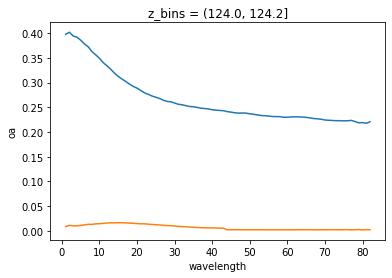

In [12]:
def i2z(i): return 15.1 + 0.20*i
def z2i(z): return int((z - 15.0)*5)
sm.oa[z2i(124.0)].plot()
ss.oa[z2i(124.0)].plot()

In [13]:
# from u let's try building sm and ss using the pandas DataFrame method

In [14]:
sm

<xarray.Dataset>
Dimensions:       (z_bins: 885, wavelength: 83)
Coordinates:
  * z_bins        (z_bins) object (15.0, 15.2] (15.2, 15.4] ... (191.8, 192.0]
  * wavelength    (wavelength) int32 0 1 2 3 4 5 6 7 ... 75 76 77 78 79 80 81 82
Data variables:
    oa            (z_bins, wavelength) float64 nan nan nan ... 0.21 0.2142
    ba            (z_bins, wavelength) float64 nan nan nan ... 0.1167 0.1172
    wavelength_a  (z_bins, wavelength) float64 nan nan nan ... 730.7 734.0 737.8
    wavelength_c  (z_bins, wavelength) float64 nan nan nan ... 731.5 735.3 738.8
    lat           (z_bins) float64 nan nan nan nan ... 44.53 44.53 44.53 44.53
    lon           (z_bins) float64 nan nan nan nan ... -125.4 -125.4 -125.4

In [15]:
sm.wavelength_a[19][23]

<xarray.DataArray 'wavelength_a' ()>
array(493.4)
Coordinates:
    z_bins      object (18.8, 19.0]
    wavelength  int32 23

In [16]:
sm.oa[10]

<xarray.DataArray 'oa' (wavelength: 83)>
array([       nan, 0.41400807, 0.41345352, 0.41002398, 0.406671  ,
       0.40507176, 0.39925532, 0.39218378, 0.3868565 , 0.3820011 ,
       0.37466399, 0.36786627, 0.36105129, 0.35586958, 0.3491621 ,
       0.34402262, 0.33773781, 0.33414286, 0.33054947, 0.32519811,
       0.32111595, 0.31683954, 0.31257319, 0.30834062, 0.30455377,
       0.30142115, 0.29781416, 0.29421336, 0.29107877, 0.28852163,
       0.28639262, 0.28356934, 0.28091301, 0.2791163 , 0.27746933,
       0.27588845, 0.27424938, 0.27248608, 0.27099411, 0.26988689,
       0.2685633 , 0.26708061, 0.26661129, 0.26600657, 0.26455931,
       0.26283272, 0.26149611, 0.26090543, 0.26036225, 0.25905151,
       0.2586185 , 0.25709433, 0.25525494, 0.25457033, 0.2538882 ,
       0.2528416 , 0.25325943, 0.25227104, 0.25219765, 0.25157741,
       0.2519439 , 0.25264334, 0.25390675, 0.25479701, 0.25599931,
       0.25541807, 0.25508507, 0.2532454 , 0.25101903, 0.24950096,
       0.24682579, 0.24593037, 0.24480865, 0.24337446, 0.24432222,
       0.24347339, 0.24421119, 0.2440721 , 0.24195792, 0.24062805,
       0.23925863, 0.23743567, 0.23905113])
Coordinates:
    z_bins      object (17.0, 17.2]
  * wavelength  (wavelength) int32 0 1 2 3 4 5 6 7 8 ... 75 76 77 78 79 80 81 82

In [17]:
n_z_bins = len(sm.z_bins)
n_w_bins = len(sm.wavelength)

In [18]:
sm.wavelength_a[20]

<xarray.DataArray 'wavelength_a' (wavelength: 83)>
array([399.6, 403.2, 406.2, 409.3, 413. , 416.6, 420.1, 424.2, 428.6,
       432.5, 436.1, 440. , 444.2, 449. , 453.2, 457.8, 462. , 466.2,
       471. , 475.7, 480.8, 485.3, 489.5, 493.4, 498.1, 502.4, 507.4,
       511.8, 517. , 521.3, 526. , 530.3, 534.7, 538.5, 543.3, 547.5,
       552.1, 556. , 560.8, 565.2, 569.1, 573. , 577.1, 581.2, 583.6,
       587.4, 591.8, 596. , 600.6, 605. , 609.7, 614.2, 618.4, 623. ,
       626.7, 631.2, 635. , 639.3, 643.1, 647.4, 652.4, 656.5, 660.9,
       665. , 669.3, 673.6, 677.5, 681.9, 686.1, 689.8, 693.4, 697.3,
       701.2, 704.9, 708.6, 712.3, 716. , 719.5, 723. , 726.8, 730.7,
       734. , 737.8])
Coordinates:
    z_bins      object (19.0, 19.2]
  * wavelength  (wavelength) int32 0 1 2 3 4 5 6 7 8 ... 75 76 77 78 79 80 81 82

In [19]:
wav_ref = sm.wavelength_a[0][0:3]
print(wav_ref)

<xarray.DataArray 'wavelength_a' (wavelength: 3)>
array([nan, nan, nan])
Coordinates:
    z_bins      object (15.0, 15.2]
  * wavelength  (wavelength) int32 0 1 2


#### Put this NaN in the reference and add import curve_fit to the Module

```
x = float(nan)
pd.isna(x)
np.isnan(x)
math.isnan(x)
Python: Is not equal to itself: if x != x: will be true if x is NaN
Python: It will not fall within a big range: if float('-inf') < float(num) < float('inf'):
```

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880


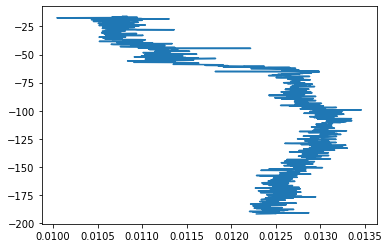

In [20]:
from scipy.optimize import curve_fit
def func(x, a, b, c): return a * np.exp(-b * x) + c


gamma, depth = [], []

for i in range(n_z_bins):
    
    if not i%20: print(i)
    
    oa, wav = [], []
    for j in range(n_w_bins):
        if not pd.isna(float(sm.oa[i][j])):
            oa.append(float(sm.oa[i][j]))
            wav.append(float(sm.wavelength_a[i][j])-403.2)
            
    # print(len(oa), len(wav))
    # print(len(oa), len(wav), oa[20], wav[20])
    # print(type(oa))
    # plt.plot(wav, oa)
    
    if len(oa) > 3:
        popt, pcov = curve_fit(func, wav, oa)
        # print(len(oa), len(wav), popt)
        gamma.append(popt[1])
        depth.append(-i2z(i))

plt.plot(gamma, depth)

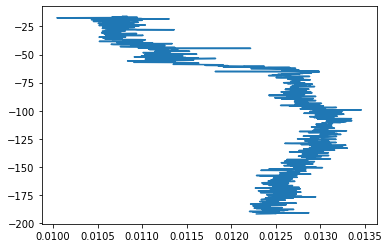

In [21]:
plt.plot(gamma, depth)

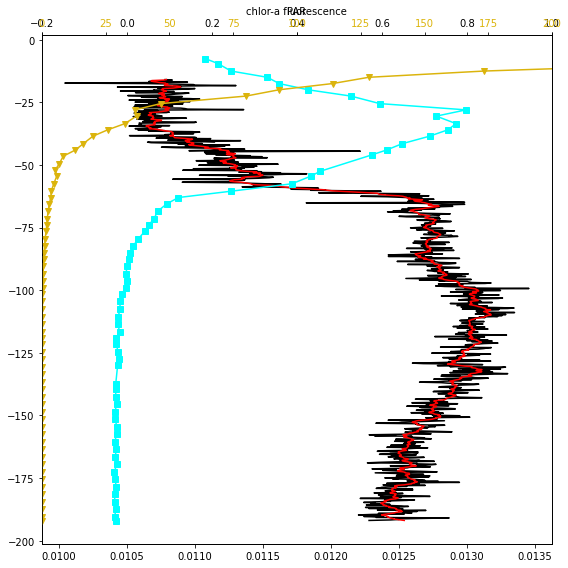

In [22]:
def smooth(y, n):
    '''
    Boxcar smoothing; it assumes x-spacing even
    '''
    r, idx = [], []
    for i in range(0, len(y)):
        ii, jj, s, np = max(i - n, 0), min(i + n, len(y)-1), 0, 0
        for k in range(ii, jj + 1):
            if y[k] > 0.: s, np  = s + y[k], np + 1
        if np:
            r.append(s/np)
            idx.append(i)
    return r, idx

g_s, i_s = smooth(gamma, 5)
fig,ax=plt.subplots(figsize=(8,8),tight_layout=True)
atA = ax.twiny()
# atP = ax.twiny()

ax.plot(gamma, depth, color='k')
ax.plot(g_s, depth, color='r')

atA.set_xlabel('chlor-a fluorescence', color='k')
atA.plot(A.chlora, A.z, marker='s', markersize = 6., color='cyan', markerfacecolor='cyan')
atA.tick_params(axis='x', labelcolor='k')
atA.set(xlim = (-0.2, 1.0))

if False:
    atB = ax.twiny()
    atB.set_xlabel('bb700', color='k')
    atB.plot(B.backscatter, B.z, marker='s', markersize = 6., color='magenta', markerfacecolor='magenta')
    atB.tick_params(axis='x', labelcolor='magenta')
    atB.set(xlim = (0., .002))

atP = ax.twiny()
atP.set_xlabel('PAR', color='k')
atP.plot(P.par, P.z, marker='v', markersize = 6., color='xkcd:gold', markerfacecolor='xkcd:gold')
atP.tick_params(axis='x', labelcolor='xkcd:gold')
atP.set(xlim = (0., 200.))

plt.show()

In [23]:
A

<xarray.Dataset>
Dimensions:  (time: 65)
Coordinates:
  * time     (time) datetime64[ns] 2021-03-13T20:42:00 ... 2021-03-13T21:48:00
Data variables:
    chlora   (time) float64 -0.02483 -0.028 -0.02631 ... 0.245 0.2141 0.184
    z        (time) float64 -192.0 -190.5 -187.5 -184.5 ... -12.5 -9.5 -7.5
Attributes: (12/44)
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    104289
    summary:                       Timeseries data from 'Regional Cabled Arra...
    time_coverage_end:             2021-08-02T23:59:00Z
    time_coverage_start:           2014-10-06T14:10:00Z
    title:                         Regional Cabled Array: Oregon Slope Base S...

### Move this to reference: How to fit to an exponential

Need to resolve the "fit to x relative to x0" business.

```
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

def func(x, a, b, c): return a * np.exp(-b * x) + c

xdata = np.linspace(0, 4, 50)

y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()

# null hypothesis produces gamma = 1.3 as desired
# y_noise = [0.]*len(xdata)
y_noise = 0.2 * rng.normal(size=xdata.size)

ydata = y + y_noise
print(type(ydata))

popt, pcov = curve_fit(func, xdata, ydata)
print(popt[1], type(popt[1]))
```

### Move to ref with the cell above


```
fig,ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(xdata, ydata, 'b-', label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
```

### Code fragments


The following code pertains to multi-plot building, data subsets and interactive views of the data. 
It should be relocated out of this notebook to the reference material. 


```
# declaring figure and axes
# fig, axs = plt.subplots(fig_n_down, fig_n_across, figsize=(fig_width * fig_n_across, fig_height*fig_n_down), tight_layout=True)

# referencing one of these axes
# axs[day_index][3]

# using index selection 
# .isel(wavelength=oa_plot_wavelength)

################################
# interact example
################################

# intro text:
# We have two charts per day (midnight and noon) and two observation types (OA and BA). This is 2 x 2 charts. 
#   The display is 2 such blocks, left and right, for 4 x 2 charts. When the checkbox is True we use the passed
#   values for the right chart and the stored values for the left. When the checkbox is False we use the passed
#   values for the left chart and the stored values for the right. In either case the updated states are stored
#   in global state variables. If the day is 0 there is no plot. A four-chart state is { day_ba, day_oa, channel_oa }.

# sliders etc set up:
# interact(spectrophotometer_display, \
#          sel_day_ba=widgets.IntSlider(min=1, max=31, step=1, value=9,  continuous_update=False, description='BAtten'),
#          sel_day_oa=widgets.IntSlider(min=1, max=31, step=1, value=9,  continuous_update=False, description='OAbs'),
#          sel_channel_oa=widgets.IntSlider(min=1, max=82, step=1, value=49,  continuous_update=False, description='OA Chan'),
#          right = widgets.ToggleButton(value=False, description='use right charts', disabled=False,
#              button_style='', tooltip='Description', icon='check')
#     )

# corresponding function: 
# def spectrophotometer_display(sel_day_ba, sel_day_oa, sel_channel_oa, right):
```

# Part 3. Residual notes


[`optaa` site at OOI](https://oceanobservatories.org/instrument-class/optaa/)

    

* AC-S on the Oregon Slope Base shallow profiler: midnight and noon ascents
    * **First is 7:22 Zulu: midnight off the coast of Oregon**
    * RCA shallow profilers execute nine profiles per day from 200m to 5m nominal depths
    * Ascent duration is an hour
    * Nitrate measures on *descent*
    * The ascent minimum depth is five meters but is typically more, varying with sea conditions
* AC-S: optical absorption (**OA**), beam attenuation (**BA**)
    * With time and pressure in dbar; depth in m
    * Instrument sampling rate is ~3.7 samples per second
    * Instrument records 86 spectral channels
        * Light wavelength is ~(400nm + channel number x 4nm)
        * Channel width is ~20nm so channels overlap
        * Signals shift with wavelength
    * Channels 0, 83, 84 and 85 tend to give `nan` values (not usable) for both OA and BA
        * Tend to use channels 2 through 82
    * Both OA and BA data are idiosyncratic
        * The midnight OA data are quantized in a peculiar manner; see charts below
        * The noon OA are *somewhat* quantized but have more reasonable / data-like structure
        * BA data are not fraught with the OA quantization issue
            * Both midnight and noon BA data include substantial noise
            * Variance is also apparent in BA data
            * This suggests filtering by depth bin and possibly discarding outliers
* Un-answered questions
    * Is this particular time interval simply 'instrument fail'?
    * Why are OA data different in midnight versus noon profiles? 
    * Are OA and BA typically combined into a turbidity value?
    * What wavelength ranges are of particular interest?
    * How do these signals compare with fluorometers, nitrate, CTD, pH, etcetera? 
        * OOI site has SME remarks circa 2016 (not illuminating)
* References from OOI
    * [Table of instruments / designators / locations](https://oceanobservatories.org/instrument-series/optaad/)
    * [Spectrophotometer page](https://oceanobservatories.org/instrument-class/optaa/)
    * [Subject Matter Expert evaluation](https://oceanobservatories.org/2016/07/successful-sme-evaluation-spectrophotometer-optaa/)
    * [Code](https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/opt_functions.py)


Paraphrasing the Subject Matter Export evaluation (link above): 


> Dr. Boss (SME) verified 1.5 months of data (April-May 2015): Processing and plotting data using the raw data and vendor calibration files 
> from the AC-S, salinity and temperature from a collocated CTD data to correct absorption and attenuation median spectra and scattering, 
> and data from a collocated fluorometer to cross-check the chlorophyll and POC results.
> 
> Consistency between the sensors suggests that they did not foul during the deployment. Not only did his results show that accurate data 
> was being produced by all the sensors in question, but the AC-S (an extremely sensitive instrument normally deployed for very short periods
> of time) did not drift noticeably during the deployment period, a notable achievement.



Paraphrased from the [sheet on Optical Absorption (**OA**)](https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00700_Data_Product_SPEC_OPTABSN_OOI.pdf):


> The OPTAA is a WET Labs AC-S spectral absorption and attenuation meter. 
Total wavelength span is 400–750 nm in approximately 
4 nm steps. Individual filter steps (channels) have a full-width half maximum response 
between about 10 to 18 nm. 


> 35 OPTAA instruments are deployed
throughout the initial OOI construction: Pioneer, Endurance, Regional and
Global arrays.



> Depends on a calibrated instrument as well as water temperature and practical
salinity derived from a co-located and synchronized CTD. 


> While small corrections
for salinity are available at visible wavelengths (< 700 nm), temperature and salinity corrections
are more significant at infrared wavelengths (> 700 nm) and must be performed on both the
absorption and attenuation signals.


The [beam attenuation (**BA**) sheet](https://oceanobservatories.org/wp-content/uploads/2015/10/1341-00690_Data_Product_SPEC_OPTATTN_OOI.pdf)
is similar. Both give a mathematical basis for the data as well as code. 
